In [1]:
import torch
device = 'cuda:0'
#device = 'cuda:1'
device = device if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
from tqdm import tqdm
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass, field

from PIL import Image
import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as albu

from segmentation_models_pytorch import *

import numpy as np
from datasets import load_dataset
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [3]:
id2label: Dict[str, str] = {
    "0": "Background",
    "1": "Ausgebaute Allwetterstrasse",
    "2": "Eisenbahn",
    "3": "Fußweg",
    "4": "Karawanenweg",
    "5": "Saumweg",
}
label2id: Dict[str, str] = {v: k for k, v in id2label.items()}
num_labels: int = len(id2label)

In [4]:
import datasets
import glob
from sklearn.model_selection import train_test_split

root_path = "data/RoadSeg"
# Define file paths
train_IMAGES = sorted(glob.glob(root_path+"/Train/Image/*.tif"))
train_SEG_MAPS = sorted(glob.glob(root_path+"/Train/Mask/*.tif"))

val_IMAGES = sorted(glob.glob(root_path+"/Val/Image/*.tif"))
val_SEG_MAPS = sorted(glob.glob(root_path+"/Val/Mask/*.tif"))

test_IMAGES = sorted(glob.glob(root_path+"/Test/Image/*.tif"))
test_SEG_MAPS = sorted(glob.glob(root_path+"/Test/Mask/*.tif"))

# # Split the dataset
# train_images, val_test_images, train_masks, val_test_masks = train_test_split(
#     train_IMAGES + val_IMAGES, train_SEG_MAPS + val_SEG_MAPS, test_size=0.2, random_state=42
# )

# val_images, test_images, val_masks, test_masks = train_test_split(
#     val_test_images, val_test_masks, test_size=0.5, random_state=42
# )

# Create datasets
train_dataset_raw = datasets.Dataset.from_dict(
    {"image": train_IMAGES, "mask": train_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

val_dataset_raw = datasets.Dataset.from_dict(
    {"image": val_IMAGES, "mask": val_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

test_dataset_raw = datasets.Dataset.from_dict(
    {"image": test_IMAGES, "mask": test_SEG_MAPS},
    features=datasets.Features({"image": datasets.Image(),"mask": datasets.Image()})
)

# Print dataset information
print("Train Dataset:", train_dataset_raw)
print("Validation Dataset:", val_dataset_raw)
print("Test Dataset:", test_dataset_raw)


Train Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 4953
})
Validation Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 1415
})
Test Dataset: Dataset({
    features: ['image', 'mask'],
    num_rows: 708
})


In [5]:
class CustomDataset(Dataset):
    def __init__(self, train_dataset, transform=None):
        self.images_fps = train_dataset[:]['image']
        self.masks_fps = train_dataset[:]['mask']
        self.transform = transform

    def __len__(self):
        return len(self.images_fps)

    def __getitem__(self, i):
        image = torch.tensor(np.array(self.images_fps[i].convert("RGB")))
        mask = torch.tensor(np.array(self.masks_fps[i]))
        if self.transform:
            transformed = self.transform(image=image.cpu().numpy(), mask=mask.cpu().numpy())
            image = torch.tensor(transformed['image']).to(device)
            mask = torch.tensor(transformed['mask']).to(device)


        image = torch.permute(image, (2, 0, 1))
        return {"pixel_values": image, "labels": mask}


In [6]:
def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.GaussNoise (p=0.2),
        #albu.Perspective(p=0.5),

        albu.OneOf(
            [
                #albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.5,
        ),
    ]
    return albu.Compose(train_transform)

In [7]:
train_dataset = CustomDataset(train_dataset=train_dataset_raw, transform=get_training_augmentation())

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\albumentations\augmentations\transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [8]:
val_dataset = CustomDataset(train_dataset=val_dataset_raw, transform=None)

In [9]:
test_dataset = CustomDataset(train_dataset=test_dataset_raw, transform=None)

In [10]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=6,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

model = model.to(device)

model.device

C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias']
Y

device(type='cuda', index=0)

In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def get_validation_scores(model, data_loader, loss_fn):
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  y_true = np.array([])
  y_pred = np.array([])
  loss_sum = 0

  model.eval()
  with torch.inference_mode():
    for batch in tqdm(data_loader):
      input_ids = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)

      inputs = processor(images=input_ids, return_tensors="pt").to(device)
    
      outputs = model(inputs["pixel_values"].to(device).float())

      downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

      loss = loss_fn(outputs["logits"], downsampled_labels)
      loss_sum += loss.item()

      preds = torch.argmax(outputs["logits"], dim=1)

      y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
      y_pred=np.append(y_pred, [preds.cpu().numpy()])

    include_label = [1,2,3,4,5]
    F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
    acc = accuracy_score(y_true.flatten(), y_pred.flatten())

    f1 = np.asarray(F1)
    iou = np.asarray(IOU)
    prec = np.asarray(Precision)
    rec = np.asarray(Recall)

  return {
      "fscore": f1.mean(),
      "iou": iou.mean(),
      "precision": prec.mean(),
      "recall": rec.mean(),
      "accuracy": acc.mean(),
      "loss": loss_sum/len(data_loader)
  }

In [12]:
import datetime
def train(model, train_loader, val_loader, optim, loss_fn, num_epochs, valid_every, processor=None):
  best_fscore = 0.0
  max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
  for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader):
      optim.zero_grad()
      inputs = batch['pixel_values'].to(device)
      labels = batch['labels'].to(device)
      if processor != None:
        inputs = processor(images=inputs, return_tensors="pt")["pixel_values"]
      outputs = model(inputs.to(device).float())

      downsampled_labels  = max_pool(labels.float().unsqueeze(0)).squeeze()

      loss = loss_fn(outputs["logits"].float(), downsampled_labels.long())
      loss.backward()
      optim.step()

      epoch_loss += loss.item()

    print(f"Epoch: {epoch+1}, Loss: {epoch_loss / len(train_loader)}")
    epoch_loss = 0
    if epoch % valid_every == 0:
      results = get_validation_scores(model, val_loader, loss_fn)
      print(f"Validation: Loss: {results['loss']:.6f} | F1-Score: {results['fscore']*100:.2f}% | IoU: {results['iou']*100:.2f}% | Precision: {results['precision']*100:.2f}% | Recall: {results['recall']*100:.2f}% | Accuracy: {results['accuracy']*100:.2f}%")
      if results['fscore'] > best_fscore:
        best_fscore = results['fscore']
        torch.save(model, f"model-newaug-{datetime.date.today()}.pt")
        print(f"Model saved at {epoch+1} epoch")


In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = smp.losses.FocalLoss(mode="multiclass")
NUM_EPOCHS=300
VALID_EVERY=1

train(model=model,
      processor=processor,
      train_loader=train_loader,
      val_loader=val_loader,
      optim=optim,
      loss_fn=loss_fn,
      num_epochs=NUM_EPOCHS,
      valid_every=VALID_EVERY)

100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [10:03<00:00,  1.95s/it]


Epoch: 1, Loss: 0.2223648806372958


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:08<00:00,  1.30it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.057546 | F1-Score: 4.96% | IoU: 2.83% | Precision: 13.34% | Recall: 3.05% | Accuracy: 97.93%
Model saved at 1 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 2, Loss: 0.050862519887666546


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.37it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.033675 | F1-Score: 11.05% | IoU: 7.36% | Precision: 25.79% | Recall: 8.37% | Accuracy: 98.26%
Model saved at 2 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 3, Loss: 0.034301152633082484


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.026607 | F1-Score: 16.55% | IoU: 11.30% | Precision: 40.13% | Recall: 13.58% | Accuracy: 98.40%
Model saved at 3 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:39<00:00,  1.87s/it]


Epoch: 4, Loss: 0.02832684191845117


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:05<00:00,  1.35it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.023482 | F1-Score: 24.85% | IoU: 16.67% | Precision: 40.33% | Recall: 20.02% | Accuracy: 98.47%
Model saved at 4 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 5, Loss: 0.024797469293398242


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:07<00:00,  1.32it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.021482 | F1-Score: 22.67% | IoU: 15.23% | Precision: 57.50% | Recall: 17.81% | Accuracy: 98.51%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:40<00:00,  1.87s/it]


Epoch: 6, Loss: 0.022883037775154075


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.020317 | F1-Score: 36.85% | IoU: 25.08% | Precision: 72.38% | Recall: 30.01% | Accuracy: 98.57%
Model saved at 6 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 7, Loss: 0.02161593198956501


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.019544 | F1-Score: 42.24% | IoU: 28.85% | Precision: 74.54% | Recall: 33.96% | Accuracy: 98.60%
Model saved at 7 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:36<00:00,  1.86s/it]


Epoch: 8, Loss: 0.020641623551566755


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.39it/s]


Validation: Loss: 0.018911 | F1-Score: 42.69% | IoU: 28.98% | Precision: 73.33% | Recall: 33.81% | Accuracy: 98.61%
Model saved at 8 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:38<00:00,  1.87s/it]


Epoch: 9, Loss: 0.019842964993609536


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.33it/s]


Validation: Loss: 0.018418 | F1-Score: 42.00% | IoU: 28.44% | Precision: 75.66% | Recall: 32.96% | Accuracy: 98.62%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 10, Loss: 0.019192761777629776


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.018012 | F1-Score: 52.40% | IoU: 36.52% | Precision: 70.97% | Recall: 43.61% | Accuracy: 98.65%
Model saved at 10 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 11, Loss: 0.01880720142996119


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.017701 | F1-Score: 56.89% | IoU: 40.17% | Precision: 68.94% | Recall: 48.83% | Accuracy: 98.66%
Model saved at 11 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 12, Loss: 0.01840088813896141


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:05<00:00,  1.36it/s]


Validation: Loss: 0.017618 | F1-Score: 57.64% | IoU: 40.83% | Precision: 67.35% | Recall: 50.66% | Accuracy: 98.66%
Model saved at 12 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 13, Loss: 0.018056936345754133


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.017356 | F1-Score: 59.69% | IoU: 42.91% | Precision: 68.24% | Recall: 53.72% | Accuracy: 98.68%
Model saved at 13 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 14, Loss: 0.017680179775362053


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.017289 | F1-Score: 59.88% | IoU: 43.04% | Precision: 69.01% | Recall: 53.57% | Accuracy: 98.68%
Model saved at 14 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 15, Loss: 0.01741151325404644


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.017100 | F1-Score: 59.74% | IoU: 42.93% | Precision: 69.15% | Recall: 53.32% | Accuracy: 98.69%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:39<00:00,  1.87s/it]


Epoch: 16, Loss: 0.01711183465236137


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016848 | F1-Score: 60.61% | IoU: 43.82% | Precision: 69.05% | Recall: 54.46% | Accuracy: 98.70%
Model saved at 16 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:36<00:00,  1.86s/it]


Epoch: 17, Loss: 0.01694019940651713


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.016834 | F1-Score: 61.96% | IoU: 45.21% | Precision: 68.14% | Recall: 57.28% | Accuracy: 98.69%
Model saved at 17 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 18, Loss: 0.016653660687828257


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.38it/s]


Validation: Loss: 0.016899 | F1-Score: 62.38% | IoU: 45.48% | Precision: 69.18% | Recall: 57.18% | Accuracy: 98.69%
Model saved at 18 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 19, Loss: 0.01636488256194899


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:06<00:00,  1.34it/s]


Validation: Loss: 0.016854 | F1-Score: 62.47% | IoU: 45.58% | Precision: 68.90% | Recall: 57.29% | Accuracy: 98.71%
Model saved at 19 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:39<00:00,  1.87s/it]


Epoch: 20, Loss: 0.01623151965679661


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:05<00:00,  1.37it/s]


Validation: Loss: 0.016686 | F1-Score: 62.49% | IoU: 45.64% | Precision: 69.81% | Recall: 56.67% | Accuracy: 98.72%
Model saved at 20 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:37<00:00,  1.86s/it]


Epoch: 21, Loss: 0.016015492124302734


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:05<00:00,  1.37it/s]


Validation: Loss: 0.016639 | F1-Score: 62.44% | IoU: 45.60% | Precision: 70.15% | Recall: 56.39% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:36<00:00,  1.86s/it]


Epoch: 22, Loss: 0.015810005300708356


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.39it/s]


Validation: Loss: 0.017127 | F1-Score: 59.28% | IoU: 42.37% | Precision: 73.39% | Recall: 50.27% | Accuracy: 98.71%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:35<00:00,  1.86s/it]


Epoch: 23, Loss: 0.015575200541605872


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.016552 | F1-Score: 64.13% | IoU: 47.39% | Precision: 67.93% | Recall: 61.22% | Accuracy: 98.72%
Model saved at 23 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 24, Loss: 0.015382871689695505


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.016501 | F1-Score: 65.07% | IoU: 48.36% | Precision: 68.41% | Recall: 62.19% | Accuracy: 98.73%
Model saved at 24 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:26<00:00,  1.83s/it]


Epoch: 25, Loss: 0.015268136506840106


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.016675 | F1-Score: 64.92% | IoU: 48.22% | Precision: 67.95% | Recall: 62.29% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 26, Loss: 0.015009136077377104


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.41it/s]


Validation: Loss: 0.016763 | F1-Score: 62.51% | IoU: 45.71% | Precision: 72.05% | Recall: 55.58% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 27, Loss: 0.01488611026697101


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.016722 | F1-Score: 65.13% | IoU: 48.38% | Precision: 68.87% | Recall: 62.29% | Accuracy: 98.74%
Model saved at 27 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:26<00:00,  1.83s/it]


Epoch: 28, Loss: 0.0146596334739438


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.017242 | F1-Score: 63.43% | IoU: 46.65% | Precision: 71.11% | Recall: 57.45% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 29, Loss: 0.014634058369143355


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.017590 | F1-Score: 64.71% | IoU: 47.98% | Precision: 69.39% | Recall: 60.89% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 30, Loss: 0.01450912240411966


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.017152 | F1-Score: 63.48% | IoU: 46.68% | Precision: 70.26% | Recall: 58.01% | Accuracy: 98.73%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 31, Loss: 0.014277144106886078


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.016627 | F1-Score: 65.71% | IoU: 49.08% | Precision: 69.40% | Recall: 62.53% | Accuracy: 98.73%
Model saved at 31 epoch


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 32, Loss: 0.014165035872569969


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.43it/s]


Validation: Loss: 0.017240 | F1-Score: 64.65% | IoU: 47.85% | Precision: 71.13% | Recall: 59.35% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 33, Loss: 0.014205975181633426


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.43it/s]


Validation: Loss: 0.017381 | F1-Score: 63.65% | IoU: 46.84% | Precision: 69.39% | Recall: 59.02% | Accuracy: 98.71%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.84s/it]


Epoch: 34, Loss: 0.014276688470835647


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.017131 | F1-Score: 64.58% | IoU: 47.87% | Precision: 70.41% | Recall: 59.91% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.84s/it]


Epoch: 35, Loss: 0.013934836275274715


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.017590 | F1-Score: 65.45% | IoU: 48.81% | Precision: 69.27% | Recall: 62.13% | Accuracy: 98.76%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 36, Loss: 0.01379782573109673


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.018094 | F1-Score: 64.29% | IoU: 47.61% | Precision: 70.58% | Recall: 59.28% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 37, Loss: 0.013666389218621677


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.39it/s]


Validation: Loss: 0.017670 | F1-Score: 63.52% | IoU: 46.78% | Precision: 71.00% | Recall: 57.85% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 38, Loss: 0.013714922003207668


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.018120 | F1-Score: 63.91% | IoU: 47.21% | Precision: 71.21% | Recall: 58.54% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 39, Loss: 0.013649758819731012


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.018255 | F1-Score: 65.28% | IoU: 48.53% | Precision: 71.05% | Recall: 60.48% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 40, Loss: 0.01375783097990338


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.43it/s]


Validation: Loss: 0.018366 | F1-Score: 64.50% | IoU: 47.78% | Precision: 71.22% | Recall: 59.15% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 41, Loss: 0.013489041777868424


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.019222 | F1-Score: 63.02% | IoU: 46.21% | Precision: 73.12% | Recall: 55.57% | Accuracy: 98.75%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 42, Loss: 0.013481195153848779


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.41it/s]


Validation: Loss: 0.019856 | F1-Score: 64.86% | IoU: 48.35% | Precision: 68.27% | Recall: 62.96% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 43, Loss: 0.013549187192092499


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.41it/s]


Validation: Loss: 0.018821 | F1-Score: 64.82% | IoU: 48.07% | Precision: 70.22% | Recall: 60.71% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:26<00:00,  1.83s/it]


Epoch: 44, Loss: 0.013642597315652717


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.020437 | F1-Score: 60.76% | IoU: 43.98% | Precision: 75.29% | Recall: 51.66% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 45, Loss: 0.013428257931504518


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.021090 | F1-Score: 61.81% | IoU: 45.08% | Precision: 73.39% | Recall: 54.15% | Accuracy: 98.74%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.84s/it]


Epoch: 46, Loss: 0.013538033811135157


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.023508 | F1-Score: 55.77% | IoU: 39.31% | Precision: 75.83% | Recall: 45.37% | Accuracy: 98.72%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 47, Loss: 0.013617439577055555


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.024020 | F1-Score: 54.61% | IoU: 38.29% | Precision: 78.33% | Recall: 43.24% | Accuracy: 98.69%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 48, Loss: 0.013381212375937932


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.027448 | F1-Score: 48.63% | IoU: 32.98% | Precision: 78.23% | Recall: 37.19% | Accuracy: 98.67%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:26<00:00,  1.83s/it]


Epoch: 49, Loss: 0.013469365473476148


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.41it/s]


Validation: Loss: 0.024785 | F1-Score: 52.64% | IoU: 36.13% | Precision: 78.20% | Recall: 40.31% | Accuracy: 98.64%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 50, Loss: 0.013734450422587894


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.43it/s]


Validation: Loss: 0.020347 | F1-Score: 49.14% | IoU: 33.38% | Precision: 78.53% | Recall: 37.65% | Accuracy: 98.69%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.84s/it]


Epoch: 51, Loss: 0.013279228699543785


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.028894 | F1-Score: 35.18% | IoU: 23.03% | Precision: 83.55% | Recall: 24.88% | Accuracy: 98.62%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 52, Loss: 0.013231348997402576


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.028292 | F1-Score: 50.33% | IoU: 33.85% | Precision: 78.49% | Recall: 37.32% | Accuracy: 98.58%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.84s/it]


Epoch: 53, Loss: 0.013542787871894337


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:04<00:00,  1.39it/s]


Validation: Loss: 0.025820 | F1-Score: 29.03% | IoU: 19.30% | Precision: 84.37% | Recall: 21.88% | Accuracy: 98.63%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 54, Loss: 0.01327520050709286


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.046259 | F1-Score: 21.97% | IoU: 12.81% | Precision: 86.09% | Recall: 13.20% | Accuracy: 98.18%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 55, Loss: 0.013276050224780076


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.078026 | F1-Score: 9.37% | IoU: 5.03% | Precision: 85.01% | Recall: 5.09% | Accuracy: 97.85%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:27<00:00,  1.83s/it]


Epoch: 56, Loss: 0.014209129518618987


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.030063 | F1-Score: 19.48% | IoU: 12.94% | Precision: 87.17% | Recall: 14.16% | Accuracy: 98.54%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 57, Loss: 0.013219389732506486


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]


Validation: Loss: 0.071890 | F1-Score: 8.93% | IoU: 4.77% | Precision: 85.49% | Recall: 4.82% | Accuracy: 97.93%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:28<00:00,  1.83s/it]


Epoch: 58, Loss: 0.013367291547418121


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.107094 | F1-Score: 0.16% | IoU: 0.08% | Precision: 38.24% | Recall: 0.08% | Accuracy: 97.79%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 59, Loss: 0.013755444470312326


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.242348 | F1-Score: 0.03% | IoU: 0.02% | Precision: 38.13% | Recall: 0.02% | Accuracy: 97.78%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 60, Loss: 0.014791891997259471


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:03<00:00,  1.40it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.066236 | F1-Score: 4.72% | IoU: 2.65% | Precision: 76.93% | Recall: 2.69% | Accuracy: 98.00%


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [09:29<00:00,  1.84s/it]


Epoch: 61, Loss: 0.01373356252968792


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [01:02<00:00,  1.42it/s]
C:\Users\U-III\.conda\envs\roadseg_hf\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: Loss: 0.041782 | F1-Score: 5.85% | IoU: 3.27% | Precision: 54.91% | Recall: 3.33% | Accuracy: 98.01%


 93%|██████████████████████████████████████████████████████████████████████████▌     | 289/310 [08:54<00:38,  1.85s/it]


KeyboardInterrupt: 

In [14]:
best_model = torch.load('model-newaug-2024-01-02.pt')
best_model = best_model.to(device)

In [15]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

y_true = np.array([])
y_pred = np.array([])

model.eval()
for batch in tqdm(test_loader):
    input_ids = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    inputs = processor(images=input_ids, return_tensors="pt").to(device)
    with torch.inference_mode():
      outputs = best_model(inputs["pixel_values"].to(device).float())

    downsampled_labels = max_pool(labels.float().unsqueeze(0)).squeeze(dim=0)

    preds = torch.argmax(outputs["logits"], dim=1)
    y_true=np.append(y_true, [downsampled_labels.cpu().numpy()])
    y_pred=np.append(y_pred, [preds.cpu().numpy()])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:32<00:00,  1.39it/s]


In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

include_label = [1,2,3,4,5]
F1 = f1_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
IOU = jaccard_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Precision = precision_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
Recall = recall_score(y_true.flatten(), y_pred.flatten(), average=None, labels=include_label)
acc = accuracy_score(y_true.flatten(), y_pred.flatten())

f1 = np.asarray(F1)
iou = np.asarray(IOU)
prec = np.asarray(Precision)
rec = np.asarray(Recall)

metrics = np.stack((f1, iou, prec, rec), axis = 1)
df = pd.DataFrame(metrics, columns= ['F1-Score', 'IoU', 'Precision', 'Recall'])
df.index += 1
df

,F1-Score,IoU,Precision,Recall
1,0.716874,0.558693,0.733968,0.700557
2,0.673664,0.507914,0.656119,0.692173
3,0.695190,0.532791,0.708422,0.682444
4,0.672203,0.506254,0.718060,0.631851
5,0.668794,0.502397,0.711957,0.630566


In [17]:
print(f"F1-Score: {f1.mean()*100:.2f}%")
print(f"IoU: {iou.mean()*100:.2f}%")
print(f"Precision: {prec.mean()*100:.2f}%")
print(f"Recall: {rec.mean()*100:.2f}%")
print(f"Overall Accuracy: {acc*100:.2f}%")

F1-Score: 68.53%
IoU: 52.16%
Precision: 70.57%
Recall: 66.75%
Overall Accuracy: 98.76%


In [20]:
tr_palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse #Fahrstrasse --- Şose (0.92) ####
           2 : (204, 0, 0),  #Eisenbahn--- Demiryolu (0.38)
           3 : (230, 128, 0), #Fußweg--- Patika (5.66)
           4 : (255, 0, 0),  #Karawanenweg--- Araba yolu (6.1) ####
           5 : (0, 204, 242), #Saumweg--- Adi yol (85.59)
         }

Class_names = ['Fahrstraße', 'Eísenbahn', 'Fußweg', 'Karawanenweg', 'Saumweg']
ing_Class_names = ['Stabilized Roads', 'Railways', 'Footpaths', 'Cart Roads', 'Inferior Roads']

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 42,
              'xtick.labelsize':42,
              'ytick.labelsize':42}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten(), labels = [1,2,3,4,5])

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig(r'C:\Users\cagat\Desktop\Confusion_MC_Road.png', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

Normalized confusion matrix


<Axes: xlabel='Predicted label', ylabel='True label'>

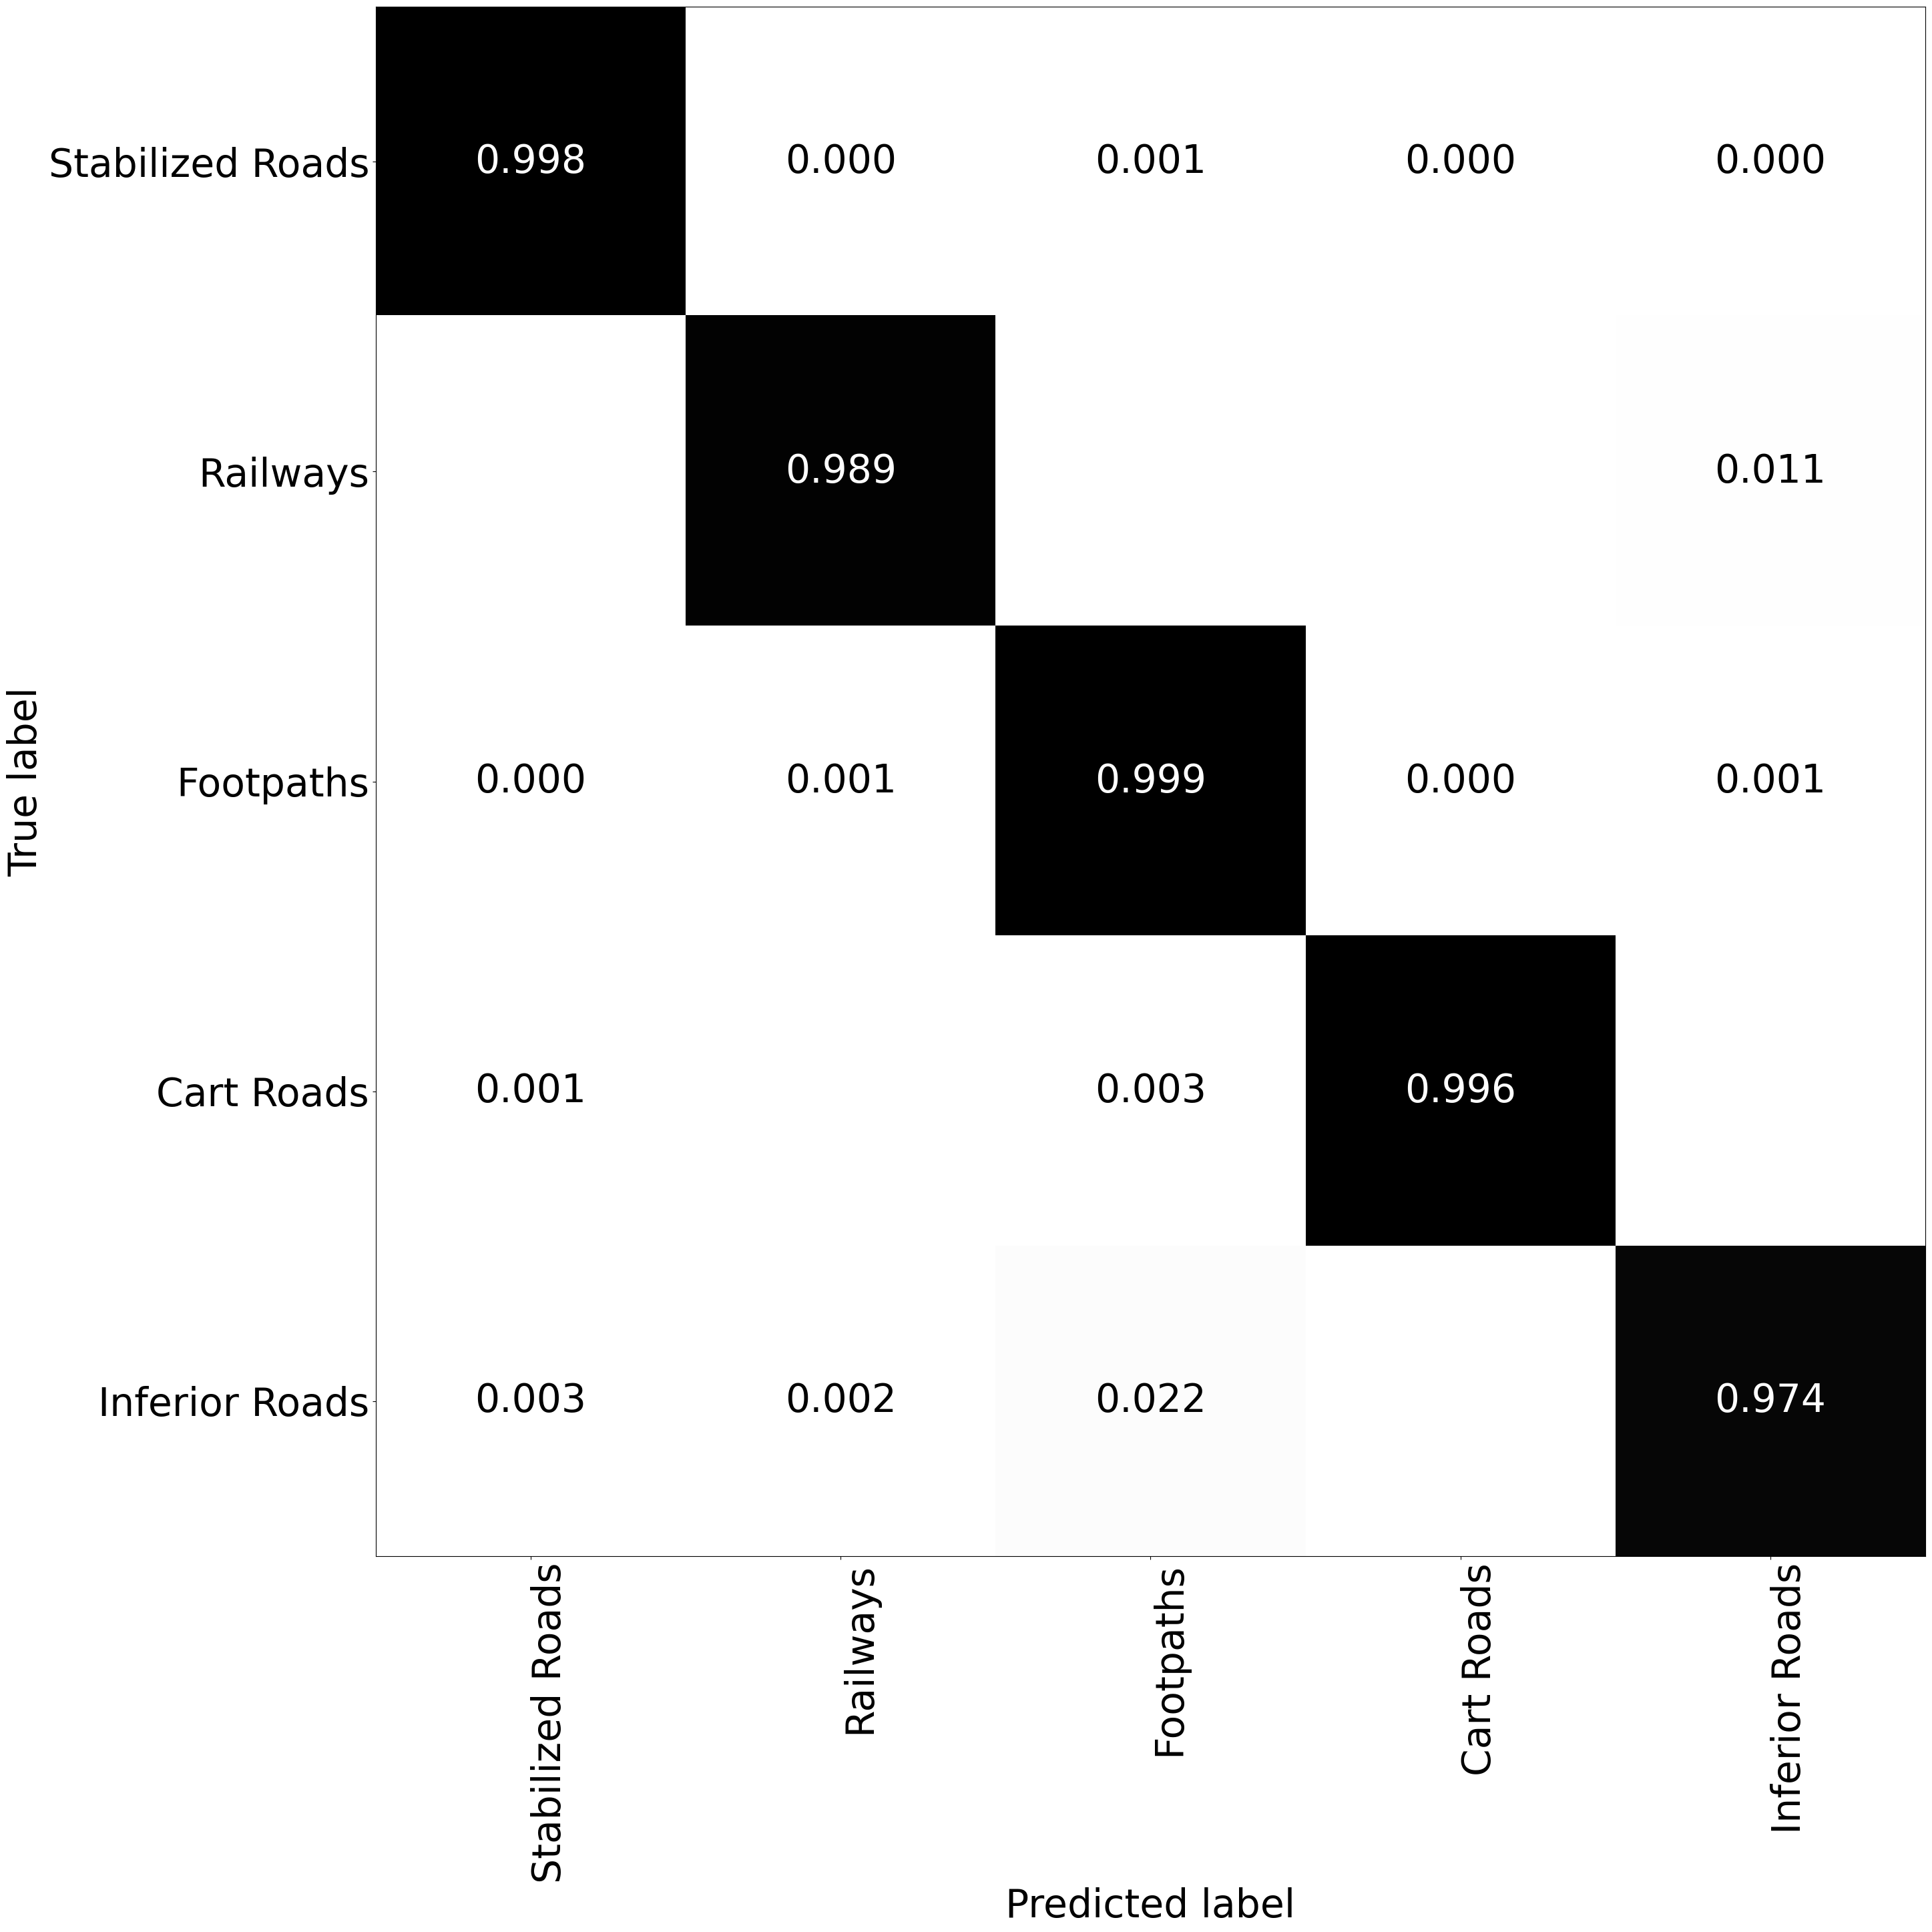

In [22]:
plot_confusion_matrix(ys=y_true,
                      y_preds=y_pred,
                      classes=ing_Class_names,
                      normalize=True)

In [23]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

palette ={ 0 : (0,0,0), # NoData
           1 : (77, 255, 0), #Ausgebaute Allwetterstrasse
           2 : (204, 0, 0),  #Eisenbahn
           3 : (230, 128, 0), #Fußweg
           4 : (255, 0, 0),  #Karawanenweg
           5 : (0, 204, 242), #Saumweg
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


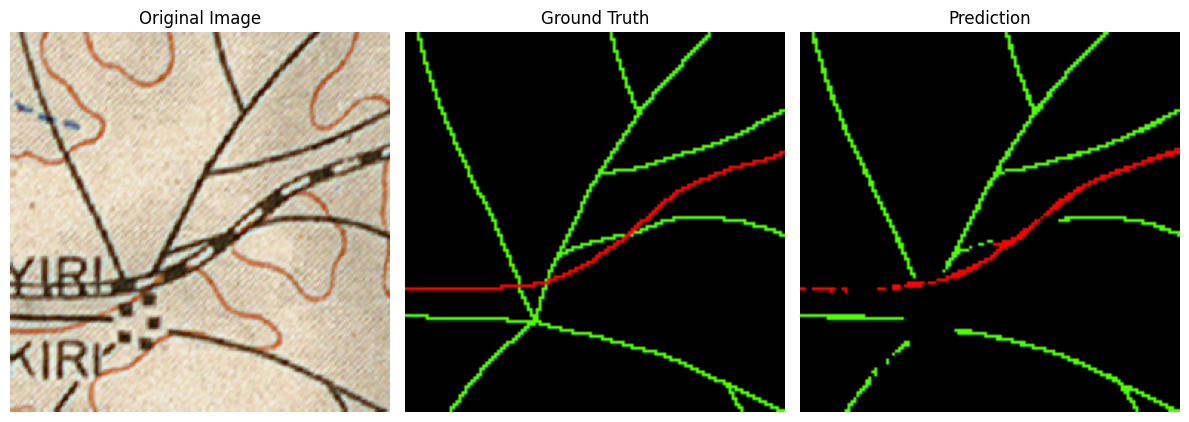

In [34]:
import matplotlib

# Reset to default parameters
matplotlib.rcdefaults()

ds = train_dataset
a = ds[np.random.randint(len(ds))]
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

model.eval()
with torch.inference_mode():
    inputs = a["pixel_values"].to(device).float()
    processed_inputs = processor(images=inputs, return_tensors="pt").to(device)
    out = best_model(pixel_values=processed_inputs["pixel_values"])
    segmented_image = convert_to_color(out["logits"].argmax(dim=1).cpu().squeeze())

    downsampled_labels = max_pool(a["labels"].float().unsqueeze(0).unsqueeze(0))

    colored_logits = convert_to_color(downsampled_labels.squeeze().cpu())
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Display the original image on the left side
    axs[0].imshow(a["pixel_values"].permute(1, 2, 0).cpu().numpy())  # Assuming shape is CxHxW
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Display the segmented image on the right side
    axs[1].imshow(colored_logits)
    axs[1].set_title('Ground Truth')
    axs[1].axis('off')

    # Display the segmented image on the right side
    axs[2].imshow(segmented_image)
    axs[2].set_title('Prediction')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
